# Research Question No. 5
This research question aims to investigate the characteristics of groups of bugs for which classifiers yield better accuracy.

# 1. Experimental parameters


| Parameter                  |         Value        |
|----------------------------|:--------------------:|
| Project                    |        Eclipse, Freedesktop, Gcc, Gnome, Mozilla, WineHQ       |
| Algorithms                 | NN |
| Metrics                    | Accuracy |
| Features                   | Long Description |
| Number of Terms            |        100       |
| Balancing                  |        Smote   |
| Resampling                 |        Repeated CV 5 x 2       |
| Threshold                  |        365       |








Every bug which its report have indicated that the number of days to resolve is less than or equal to **threshold fixed** was considered a **non-long lived bug** and that which the number of days to resolve is greater than this threshold was considered as a **long-live bug**. 

# 2. Setup environment

In [19]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [20]:
import os 
import matplotlib.pyplot  as plt 
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns 
from wordcloud import WordCloud
from scipy.stats import friedmanchisquare
from scipy.stats import kruskal

# Setup Matplotlib
plt.rc('figure', figsize=(20, 20))
plt.style.use('default')
SMALL_SIZE = 12
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=SMALL_SIZE)  # fontsize of the figure title
%matplotlib inline 

# Setup Seaborn
sns.set_context("paper")
sns.set_style("ticks")

pd.set_option('display.max_columns', None)

results_gcc_path = "datasets/rq4e4_gcc_test_results_balanced_acc.csv"
reports_gcc_path = "datasets/20190917_gcc_bug_report_data.csv"

results_eclipse_path = "datasets/rq4e4_eclipse_test_results_balanced_acc.csv"
reports_eclipse_path = "datasets/20190917_eclipse_bug_report_data.csv"

print("Setup complete")

Setup complete


# 3. Load data

In [21]:
    !echo "\nHeader of metrics file $reports_gcc_path"
    !head -n 2 $reports_gcc_path

    !echo "\nNumber of lines in the file $reports_gcc_path"
    !wc -l $reports_gcc_path
    
    !echo "\nHeader of metrics file $results_eclipse_path"
    !head -n 2 $results_eclipse_path

    !echo "\nNumber of lines in the file $results_eclipse_path"
    !wc -l $results_eclipse_path

\nHeader of metrics file datasets/20190917_gcc_bug_report_data.csv
bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code
CLASSPATH-26758,2006-03-19,awt,CLASSPATH,GdkFontPeer.getPostScriptFontName unimplemented,The Openstreetmap applet expects java.awt.Font.getPSFontName() to return something non-null.,unassigned,roman,fixed,1,resolved,4,2006-05-20,0,12,2006-05-20,62,normal,2
\nNumber of lines in the file datasets/20190917_gcc_bug_report_data.csv
489575 datasets/20190917_gcc_bug_report_data.csv
\nHeader of metrics file datasets/rq4e4_eclipse_test_results_balanced_acc.csv
bug_id,bug_fix_time,long_lived,y_hat
4DIAC-495630,38,N,N
\nNumber of lines in the file datasets/rq4e4_eclipse_test_results_balanced_acc.csv
2409 datasets/rq4e4_eclipse_test_results_balanced

In [22]:
# read data.
reports_gcc_data  = pd.read_csv(reports_gcc_path)
rows_and_cols = reports_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_gcc_path}.\n")

results_gcc_data = pd.read_csv(results_gcc_path)
rows_and_cols = results_gcc_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_gcc_path}.\n")


reports_eclipse_data  = pd.read_csv(reports_eclipse_path)
rows_and_cols = reports_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {reports_eclipse_path}.\n")

results_eclipse_data = pd.read_csv(results_eclipse_path)
rows_and_cols = results_eclipse_data.shape
print(f"There are {rows_and_cols[0]} rows and {rows_and_cols[1]} columns in {results_eclipse_path}.\n")


There are 10000 rows and 19 columns in datasets/20190917_gcc_bug_report_data.csv.

There are 2480 rows and 4 columns in datasets/rq4e4_gcc_test_results_balanced_acc.csv.

There are 10000 rows and 19 columns in datasets/20190917_eclipse_bug_report_data.csv.

There are 2408 rows and 4 columns in datasets/rq4e4_eclipse_test_results_balanced_acc.csv.



# 4. Test Results Analysis

### 4.1 Review data

In [23]:
results_gcc_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,CLASSPATH-16983,15,N,N
1,CLASSPATH-17008,342,N,N
2,CLASSPATH-17060,337,N,N
3,CLASSPATH-18312,5,N,N
4,CLASSPATH-21635,96,N,N


In [24]:
reports_gcc_data['bug_class_observed']  = reports_gcc_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [25]:
reports_gcc_data[['bug_fix_time', 'bug_class_observed']].head()

,bug_fix_time,bug_class_observed
0,62,short-lived
1,2,short-lived
2,1089,long-lived
3,11,short-lived
4,62,short-lived


In [26]:
results_eclipse_data.head()

,bug_id,bug_fix_time,long_lived,y_hat
0,4DIAC-495630,38,N,N
1,4DIAC-510820,419,Y,N
2,4DIAC-517429,229,N,N
3,4DIAC-518907,200,N,N
4,ACCELEO-308970,0,N,N


In [27]:
reports_eclipse_data['bug_class_observed']  = reports_eclipse_data['bug_fix_time'].apply(lambda t: 'long-lived' if t > 365 else 'short-lived')

In [28]:
reports_eclipse_data[['bug_fix_time', 'bug_class_observed']].head()

,bug_fix_time,bug_class_observed
0,0,short-lived
1,177,short-lived
2,1,short-lived
3,50,short-lived
4,264,short-lived


## 4.2 Results analysis

In [29]:
results_gcc_merged_data = pd.merge(
    reports_gcc_data,
    results_gcc_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_gcc_merged_data = results_gcc_merged_data[results_gcc_merged_data.long_lived == 'Y']
results_gcc_merged_data.loc[results_gcc_merged_data.long_lived == 'Y', 'status_prediction'] = results_gcc_merged_data['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')


In [30]:
results_gcc_merged_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,bug_class_observed,long_lived,y_hat,status_prediction
0,GCC-43804,2010-04-19,target,GCC,[4.6 regression] ICE in reload_cse_simplify_op...,$ gcc/xgcc -Bgcc/ -O2 -fpic -S memusage.i \nme...,rsandifo,schwab,fixed,1,resolved,4,2013-04-12,0,29,2013-04-12,1089,normal,2,long-lived,Y,N,False Negative
4,GCC-560,2000-09-21,target,GCC,[Solaris 8 x86] static code segfaults before main,If you compile static code any code with gcc o...,unassigned,rami.lehti,fixed,1,resolved,4,2003-07-25,0,2,2003-07-25,1037,normal,2,long-lived,Y,Y,True Positive
9,GCC-8340,2002-10-24,target,GCC,ICE on x86 inline asm w/ -fPIC,From: Glen Nakamura \nTo: gcc-gnats@gcc.gnu.or...,ebotcazou,glen,fixed,1,resolved,4,2014-10-13,0,10,2014-10-13,4372,normal,2,long-lived,Y,N,False Negative
11,GCC-65757,2015-04-13,libquadmath,GCC,gfortran gives incorrect result for anint with...,gfortran gives an incorrect result for the ani...,jvdelisle,bugs,fixed,1,resolved,4,2019-03-01,0,26,2017-09-16,887,normal,2,long-lived,Y,N,False Negative
12,GCC-2434,2001-03-30,target,GCC,Compilation with large file support (solaris &...,When compiling C++ programs using the flags fo...,unassigned,pnobili,fixed,1,resolved,4,2003-07-25,0,5,2003-07-25,847,normal,2,long-lived,Y,Y,True Positive


In [31]:
results_eclipse_merged_data = pd.merge(
    reports_eclipse_data,
    results_eclipse_data[['bug_id', 'long_lived', 'y_hat']],
    left_on='bug_id',
    right_on='bug_id',
    how='inner'
)
results_eclipse_merged_data = results_eclipse_merged_data[results_eclipse_merged_data.long_lived == 'Y']
results_eclipse_merged_data.loc[results_eclipse_merged_data.long_lived == 'Y', 'status_prediction']  = results_eclipse_merged_data['y_hat'].apply(lambda t: 'True Positive' if t == 'Y' else 'False Negative')

In [32]:
results_eclipse_merged_data.head()

,bug_id,creation_date,component_name,product_name,short_description,long_description,assignee_name,reporter_name,resolution_category,resolution_code,status_category,status_code,update_date,quantity_of_votes,quantity_of_comments,resolution_date,bug_fix_time,severity_category,severity_code,bug_class_observed,long_lived,y_hat,status_prediction
35,EEF-444113,2014-09-15,General,EEF,The home page of EEF said the current version ...,The home page says:\nEEF is currently released...,emft.eef-inbox,etienne.juliot,fixed,1,closed,6,2016-09-23,0,2,2016-09-23,739,normal,2,long-lived,Y,N,False Negative
41,TARGET_MANAGEMENT-251654,2008-10-21,RSE,TARGET_MANAGEMENT,System View Restore doesn't take into account ...,On object that supports Expand To we can selec...,dmcknigh,kjdoyle,fixed,1,resolved,4,2011-03-28,0,4,2011-03-28,888,normal,2,long-lived,Y,N,False Negative
48,JSDT-212668,2007-12-11,General,JSDT,[hotbug] JavaScript validation error on JSPs,This is a follow-on to bug 207589:\n\nI just t...,nitind,kathy,fixed,1,resolved,4,2010-03-03,2,14,2009-02-12,429,normal,2,long-lived,Y,Y,True Positive
49,PLATFORM-376804,2012-04-14,Releng,PLATFORM,clean up test results page to remove invalid l...,The test results page has links and sub pages ...,david_williams,david_williams,fixed,1,resolved,4,2014-11-24,0,2,2014-11-24,954,normal,2,long-lived,Y,N,False Negative
51,CDT-250037,2008-10-07,cdt-debug-cdi-gdb,CDT,Debug value view fails to update 'Value' column,Build ID: M20080911-1700\n\nSteps To Reproduce...,marc.khouzam,bimargulies,fixed,1,resolved,4,2014-01-29,0,33,2010-01-10,460,normal,2,long-lived,Y,N,False Negative


In [33]:
results_gcc_merged_data.groupby('status_prediction')['status_prediction'].agg(['count'])

,count
status_prediction,
False Negative,344
True Positive,380


In [34]:
print(75/(112+75))

0.40106951871657753


In [35]:
def plot_bar (project, data, column, n, filename):
    
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False).head(n)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['status_prediction'].value_counts(normalize=True).unstack()
    
    plt.figure(figsize=(20,20))
    fig, axis = plt.subplots(figsize=(10, 10)) 
    
    sns.despine(offset=5)
    primary   = top_n.plot(kind='barh', stacked='True',  grid='True', color=["tab:red", "tab:blue"], ax=axis)
    secondary = primary.twinx()
    
    labels = [i.get_text() for i in primary.get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    
    primary.set(xlim=(0, 1))
    primary.set_xlabel('percentage', fontsize=MEDIUM_SIZE)
    primary.set_ylabel(column, fontsize=MEDIUM_SIZE) 
    primary.set_title(project, fontsize=BIGGER_SIZE)
    primary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    primary.tick_params(axis="x", labelsize=MEDIUM_SIZE)
    
    secondary.set_yticks(primary.get_yticks())
    secondary.set_ylim(primary.get_ylim())
    secondary.set_yticklabels(labels_new)
    secondary.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')

def plot_pyramid (project, data, column, n, filename):
  
    top_g = data.groupby(column)[column].agg(['count'])
    top_s = top_g.sort_values('count', ascending=False).head(n)
    top_n = data.loc[data[column].isin(top_s.index)].groupby(column)['status_prediction'].value_counts(normalize=True).unstack()
    top_n.fillna(0, inplace=True)
    
    top_n.reset_index(inplace=True)
    top_n = top_n.sort_values('False Negative', ascending=True)
    
    #print(top_n)
    
    fig, axes = plt.subplots(figsize=(10, 10), ncols=2, sharey=False, gridspec_kw = {'wspace':0, 'hspace':0})

    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True
    #plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

    sns.despine(offset=0.5)
    sns.barplot(x="False Negative", y=column, color="tab:red", ax=axes[0], data=top_n)
    sns.barplot(x="True Positive", y=column,  color="tab:blue", ax=axes[1], data=top_n)
    
    axes[0].set(xlim=(0, 1))
    axes[0].invert_xaxis()
    axes[0].spines['left'].set_visible(False)
    axes[0].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[0].tick_params(axis="y", labelsize=MEDIUM_SIZE)
    axes[0].set_ylabel(column.title().replace("_", " ").replace("Category", "Level"), fontsize=MEDIUM_SIZE)
    axes[0].set_xlabel("False Negative", fontsize=MEDIUM_SIZE)    
    axes[0].set_xticklabels(['{:,.0%}'.format(x) for x in axes[0].get_xticks()])
    
    axes[1].set(xlim=(0, 1))
    axes[1].set_yticks([])
    axes[1].set(ylabel="")
    axes[1].tick_params(axis="x", labelsize=MEDIUM_SIZE)
    axes[1].set_xlabel("True Positive", fontsize=MEDIUM_SIZE)
    axes[1].set_xticklabels(['{:,.0%}'.format(x) for x in axes[1].get_xticks()])
    
    #sns.despine(offset=0.5)
    s = axes[1].twinx()
    labels = [i.get_text() for i in axes[0].get_yticklabels()]
    labels_new = [top_s.loc[top_s.index==i, 'count'].values[0] for i in labels]
    s.set_yticks(axes[0].get_yticks())
    s.set_ylim(axes[0].get_ylim())
    s.set_yticklabels(labels_new)
    s.tick_params(axis="y", labelsize=MEDIUM_SIZE)
    
    s.spines['top'].set_visible(False)
    s.spines['bottom'].set_visible(False)
    s.spines['right'].set_visible(False)
    s.spines['left'].set_visible(False)
        
    fig.suptitle(project, fontsize=BIGGER_SIZE)
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')

    
def plot_pie (project, data, column, n, filename):
    
    top_g  = data.groupby(column)[column].agg(['count'])
    top_s  = top_g.sort_values('count', ascending=False).head(n)
    
    #labels   =  top_s.index.tolist() 
    labels    = [f"Top {n}"]
    top_n     = top_s.reset_index()
    values    = [top_s['count'].sum()] 
    labels.append('Others')
    values.append(data.shape[0] - sum(values))
    
    fig = plt.figure(figsize=(10,10))

    ax1 = fig.add_axes([0, 0, .5, .5], aspect=1)
    ax1.pie(values, labels=labels, autopct='%1.0f%%')
    print(values)
    #fig, axis = plt.subplots(figsize=(10, 10)) 
    labels   =  top_s.index.tolist() 
    values    = top_s['count'] 
    
    ax2 = fig.add_axes([.6, .0, .5, .5], aspect=1)
    ax2.pie(values, labels=labels, autopct='%1.0f%%')
    
    
    plt.savefig(f"figures/{filename}", format="pdf", dpi=600, bbox_inches='tight')




### Reporter Name

### GCC

[148, 576]


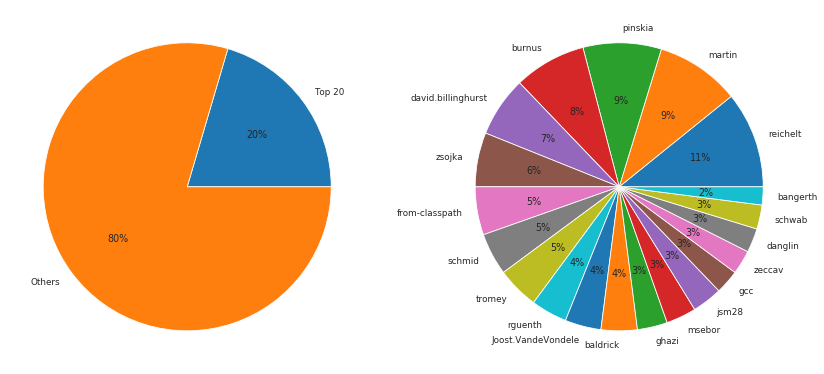

In [36]:
plot_pie('GCC', results_gcc_merged_data, 'reporter_name', 20, "rq5-gcc-tp-fn-reporter_name-pie.pdf")

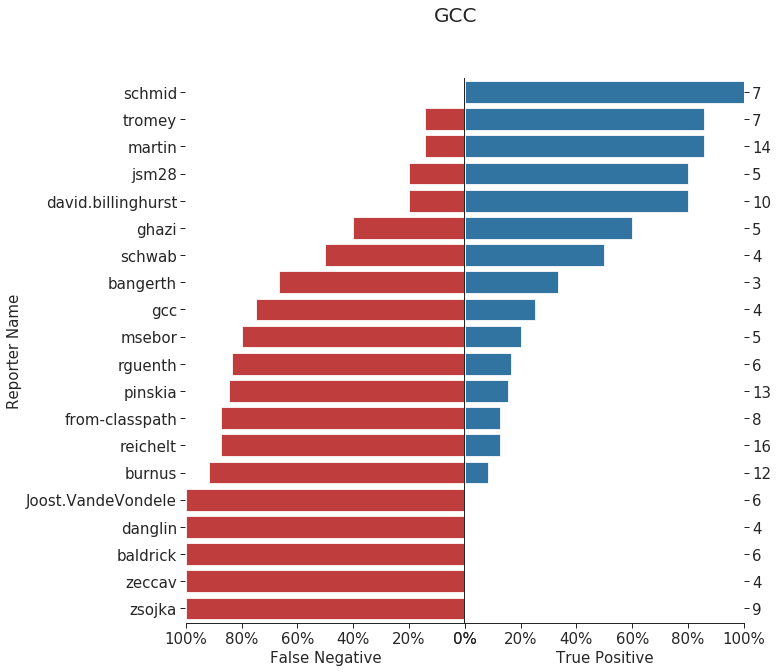

In [37]:
plot_pyramid('GCC', results_gcc_merged_data, 'reporter_name', 20, "rq5-gcc-tp-fn-reporter_name.pdf")

### Eclipse

[43, 144]


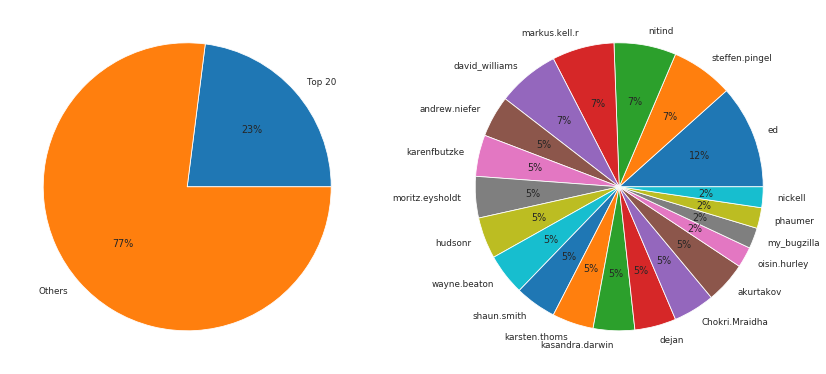

In [38]:
plot_pie('Eclipse', results_eclipse_merged_data, 'reporter_name', 20, "rq5-eclipse-tp-fn-reporter_name-pie.pdf")

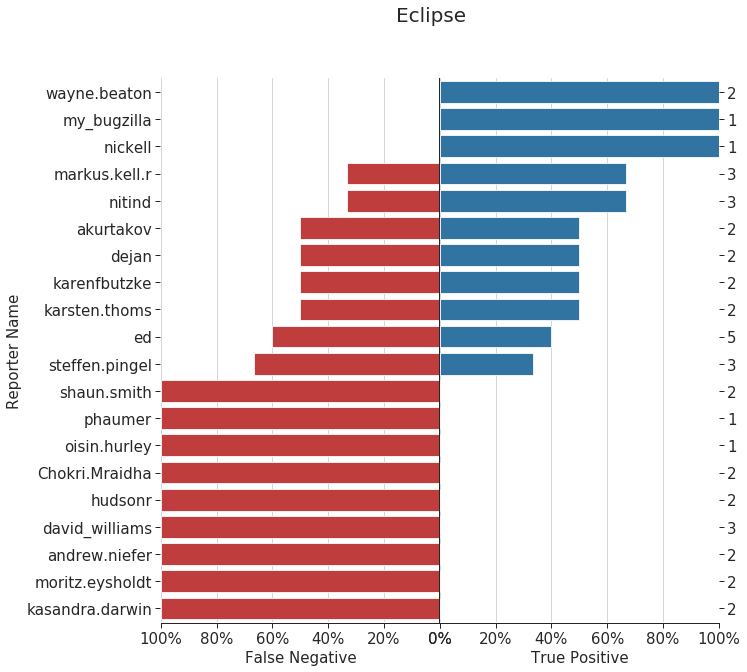

In [39]:
plot_pyramid('Eclipse', results_eclipse_merged_data, 'reporter_name', 20, "rq5-eclipse-tp-fn-reporter_name.pdf")

### Assignee

### GCC

[646, 78]


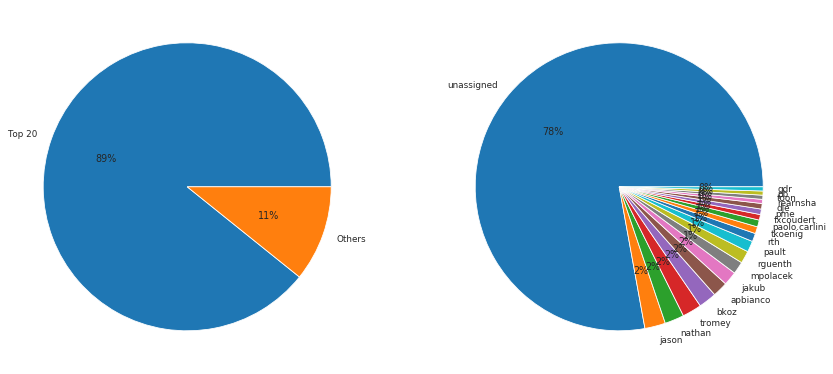

In [40]:
plot_pie('GCC', results_gcc_merged_data, 'assignee_name', 20, "rq5-gcc-tp-fn-assignee_name-pie.pdf")

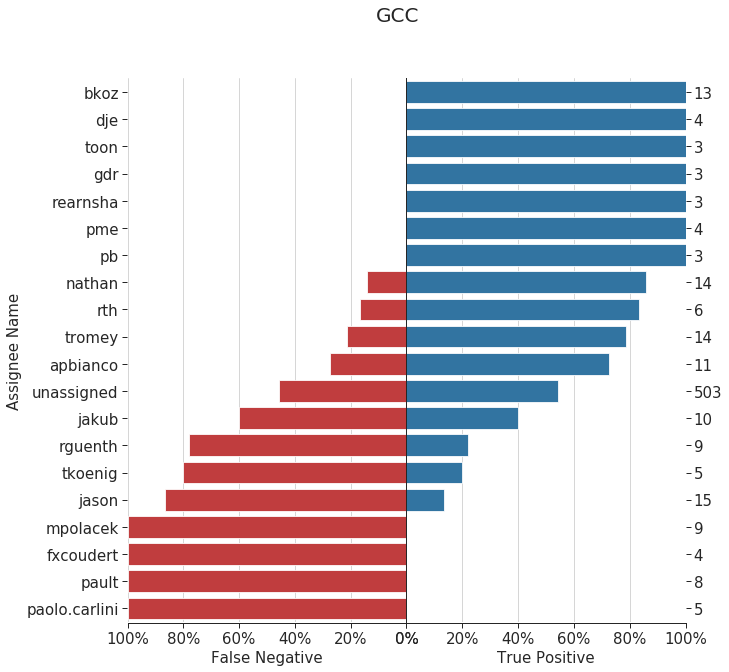

In [41]:
plot_pyramid('GCC', results_gcc_merged_data, 'assignee_name', 20, "rq5-gcc-tp-fn-assignee_name.pdf")

### Eclipse

[57, 130]


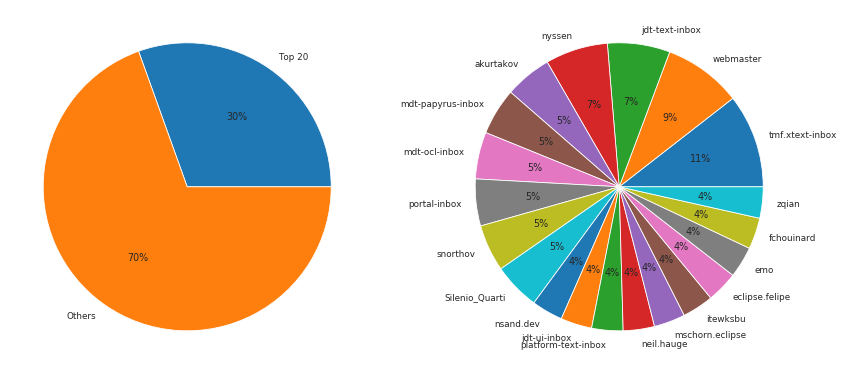

In [42]:
plot_pie('Eclipse', results_eclipse_merged_data, 'assignee_name', 20, "rq5-eclipse-tp-fn-assignee_name-pie.pdf")

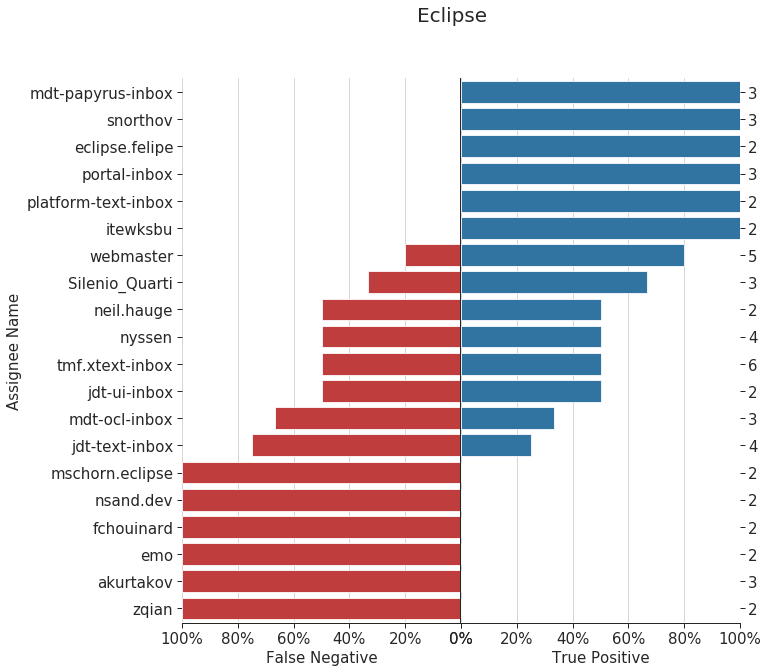

In [43]:
plot_pyramid('Eclipse', results_eclipse_merged_data, 'assignee_name', 20, "rq5-eclipse-tp-fn-assignee_name.pdf")

### Component Name

### GCC

[698, 26]


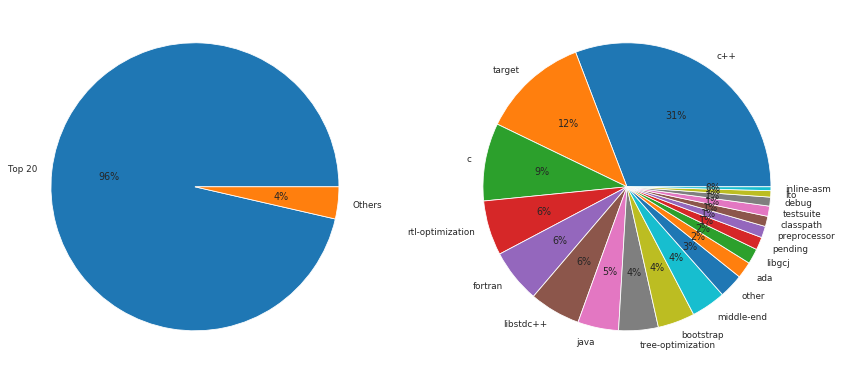

In [44]:
plot_pie('GCC', results_gcc_merged_data, 'component_name', 20, "rq5-gcc-tp-fn-component_name-pie.pdf")

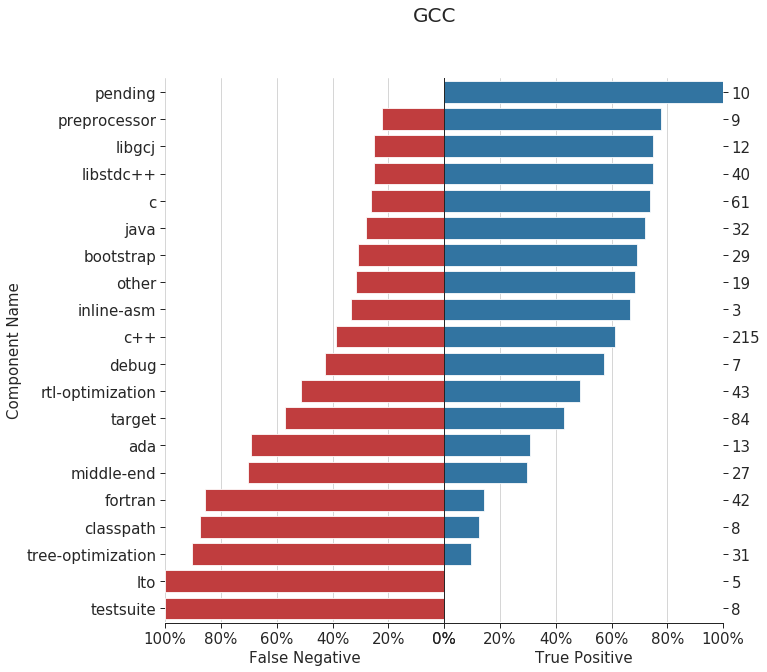

In [45]:
plot_pyramid('GCC', results_gcc_merged_data, 'component_name', 20, "rq5-gcc-tp-fn-component_name.pdf")

### Eclipse

[109, 78]


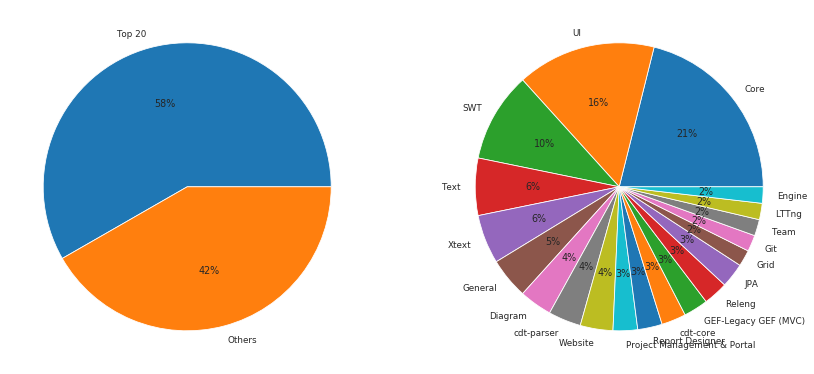

In [46]:
plot_pie('Eclipse', results_eclipse_merged_data, 'component_name', 20, "rq5-gcc-tp-fn-component_name-pie.pdf")

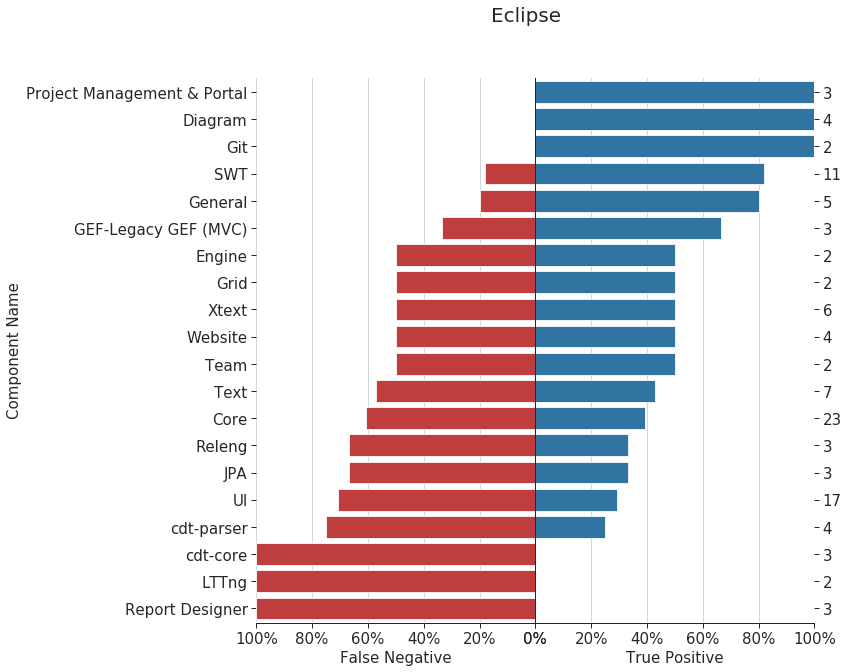

In [47]:
plot_pyramid('Eclipse', results_eclipse_merged_data, 'component_name', 20, "rq5-eclipse-tp-fn-component_name.pdf")

### Severity Level

### GCC

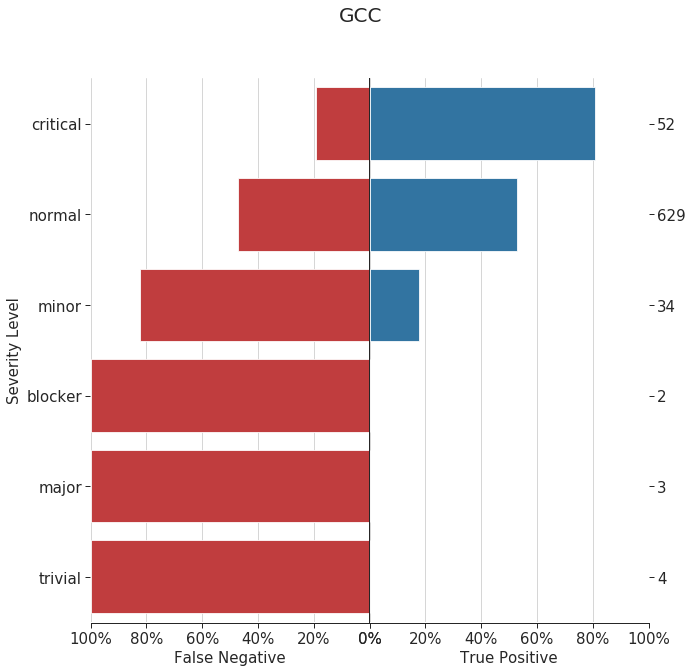

In [48]:
plot_pyramid('GCC', results_gcc_merged_data, 'severity_category',10, "rq5-gcc-tp-fn-severity_category.pdf")


### Eclipse

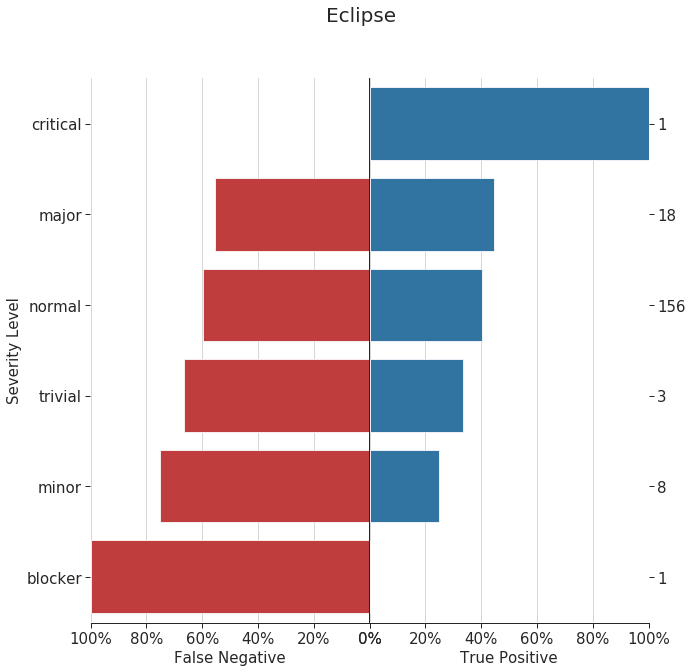

In [49]:
plot_pyramid('Eclipse', results_eclipse_merged_data, 'severity_category', 10, 'rq5-eclipse-tp-fn-severity_category.pdf')

### Description 
Existem muitas palavras relacionadas com código(stop words).

In [50]:
word_frequency_gcc_path     = "datasets/20191213_gcc_tdm_summarized.csv"
word_frequency_eclipse_path = "datasets/20191213_eclipse_tdm_summarized.csv"

word_frequency_gcc_data     = pd.read_csv(word_frequency_gcc_path) 
word_frequency_eclipse_data = pd.read_csv(word_frequency_eclipse_path)

word_frequency_eclipse_data.dropna(inplace=True)
word_frequency_gcc_data.dropna(inplace=True)

word_frequency_gcc_data['freq'] = word_frequency_gcc_data['freq'].astype(float)
word_frequency_eclipse_data['freq'] = word_frequency_eclipse_data['freq'].astype(float)

tdm_detailed_eclipse_path = "datasets/20191213_eclipse_tdm_detailed.csv"
tdm_detailed_gcc_path     = "datasets/20191213_gcc_tdm_detailed.csv"

tdm_detailed_eclipse_data = pd.read_csv(tdm_detailed_eclipse_path) 
tdm_detailed_gcc_data     = pd.read_csv(tdm_detailed_gcc_path)

tdm_detailed_eclipse_data.dropna(inplace=True)
tdm_detailed_gcc_data.dropna(inplace=True)

In [51]:
from PIL import Image
import matplotlib
def transform_format(val):
    if val == 0:
        return 255
    else:
        return val
    
def plot_word_cloud(data, status, filename):
    data = data[data['status_prediction']==status]
    #cloud_mask = np.array(Image.open("cloud.png"))
    
    word_frequency = {x[0]: x[1] for x in data.itertuples(index=False)}
    
    wordcloud = WordCloud(width=900
                      , height=500
                      , background_color='white'
                      , max_words=100
                      , colormap=matplotlib.cm.inferno
                      , relative_scaling=0
                      , normalize_plurals=False).generate_from_frequencies(word_frequency)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.savefig(f"figures/{filename}.pdf", format="pdf", dpi=600, bbox_inches='tight')

def plot_freqs(data, ylims, project, status, filename):
    data = data.loc[word_frequency_gcc_data.status_prediction==status]
    x = data['word']
    values = data['freq']

    plt.figure(figsize=(20,10))
    plt.rcParams["axes.grid.axis"] ="x"
    plt.rcParams["axes.grid"] = True
    (markerline, stemlines, baseline) = plt.stem(x, values)
    plt.setp(baseline, visible=True)
    
    plt.title(f"{project}:{status}", fontsize=SMALL_SIZE)
    plt.xticks(rotation=90, fontsize=SMALL_SIZE)
    plt.yticks(fontsize=SMALL_SIZE)
    plt.ylim(ylims)
    plt.xlabel("Terms")
    plt.ylabel("TF-IDF ratio")
    plt.grid()
    
    
    plt.savefig(f"figures/{filename}.pdf", format="pdf", dpi=600, bbox_inches='tight')

### GCC

In [52]:
word_frequency_gcc_data.head()

,word,freq,status_prediction,project
0,lib,6.889280,True Positive,gcc
1,includ,6.837264,True Positive,gcc
2,linux,6.783835,True Positive,gcc
3,usr,6.756127,True Positive,gcc
4,int,6.718097,True Positive,gcc


### True Positives

#### Word cloud

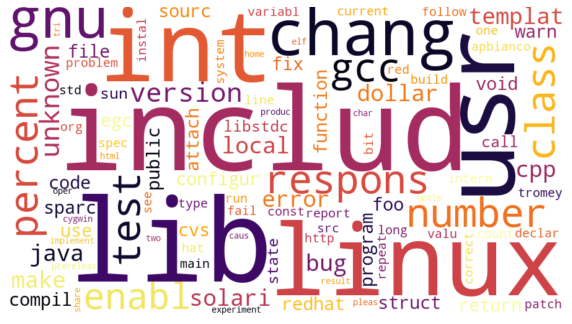

In [53]:
plot_word_cloud(word_frequency_gcc_data, 'True Positive', 'rq5-gcc-tp-word_cloud')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


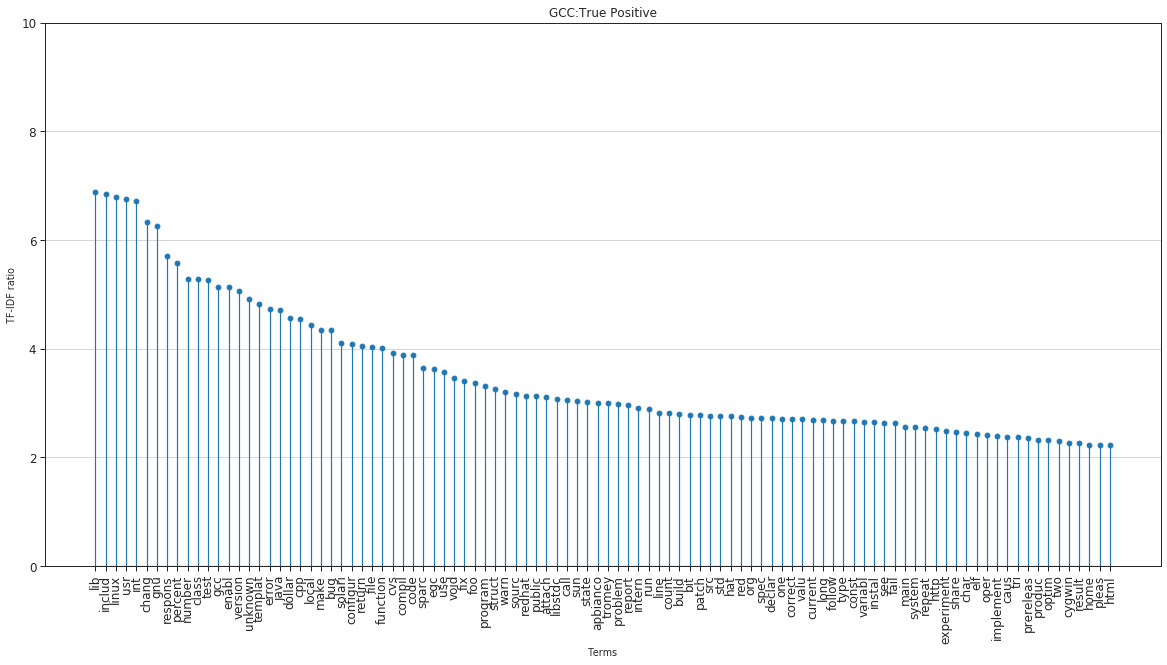

In [54]:
plot_freqs(word_frequency_gcc_data, (0,10), 'GCC', 'True Positive', 'rq5-gcc-tp-word_freqs')

#### Histograms 

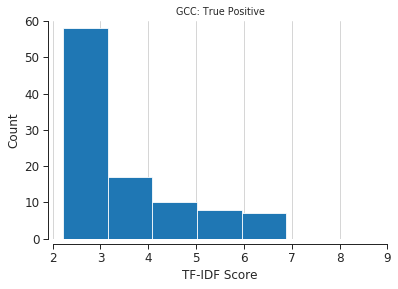

In [55]:
freqs=word_frequency_gcc_data[word_frequency_gcc_data['status_prediction']=='True Positive']['freq']

plt.hist(freqs, color='tab:blue', bins=5)
sns.despine(offset=5)

plt.title("GCC: True Positive")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)

plt.savefig('figures/rq5-gcc-tf-idf-histogram-true-positives.pdf', format="pdf", dpi=600, bbox_inches='tight')

In [56]:
from numpy import array
from numpy import count_nonzero
import numpy as np


def spy(m, ax):
    from scipy.sparse import coo_matrix
    from matplotlib.patches import Rectangle
    
    a = m.to_numpy()
    sparcity = 1.0 - ( count_nonzero(a) / float(a.size) )
    
    if not isinstance(m, coo_matrix):
        m = coo_matrix(m)
    for (x, y) in zip(m.col, m.row):
        ax.add_artist(Rectangle(
            xy=(x-0.5, y-0.5), width=1, height=1))
    ax.set_xlim(-0.5, m.shape[1]-0.5)
    ax.set_ylim(-0.5, m.shape[0]-0.5)
    ax.invert_yaxis()
    ax.set_aspect(float(m.shape[0])/float(m.shape[1]))
    ax.set_title(f"Sparcity : {sparcity}")

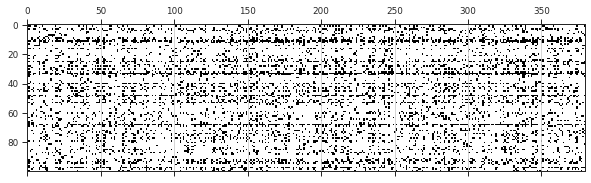

In [57]:
tdm_detailed_gcc_matrix = tdm_detailed_gcc_data.loc[tdm_detailed_gcc_data.status_prediction=='True Positive'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(tdm_detailed_gcc_matrix)
plt.savefig('figures/rq5-eclipse-tf-idf-histogram-false-negatives.pdf', format="pdf", dpi=600, bbox_inches='tight')

In [58]:
m = tdm_detailed_gcc_matrix.to_numpy()
sparsity_gcc_tp = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity_gcc_tp 

0.821921052631579

### False Negatives
---

#### Word Cloud

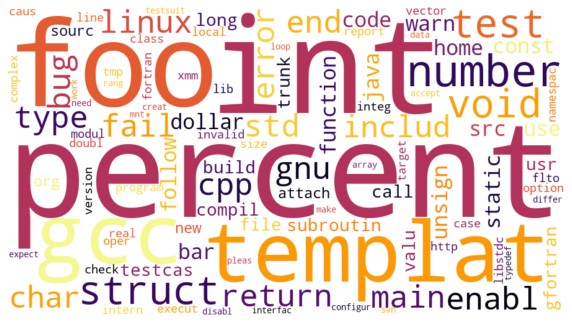

In [59]:
plot_word_cloud(word_frequency_gcc_data, 'False Negative', 'rq5-gcc-fn-word_cloud')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


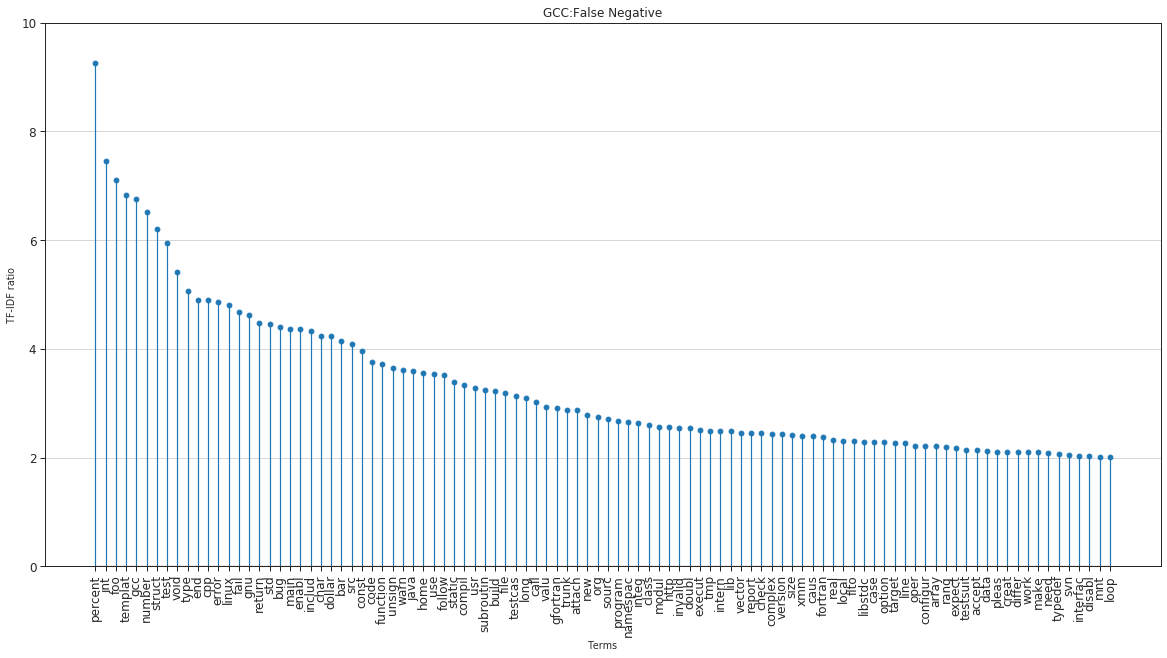

In [60]:
plot_freqs(word_frequency_gcc_data, (0, 10), 'GCC', 'False Negative', 'rq5-gcc-fn-word_freqs')

#### Histogram

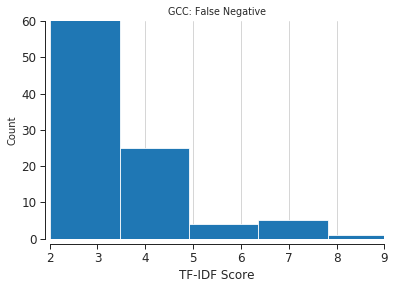

In [61]:
plt.hist(word_frequency_gcc_data[word_frequency_gcc_data['status_prediction']=='False Negative']['freq']
         , bins=5
         , color='tab:blue')
sns.despine(offset=5)
plt.title("GCC: False Negative")
plt.xticks([2, 3, 4, 5, 6, 7, 8, 9], fontsize=SMALL_SIZE)
plt.xlim(2, 9)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=10)
plt.savefig('figures/rq5-gcc-tf-idf-histogram-false-negatives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

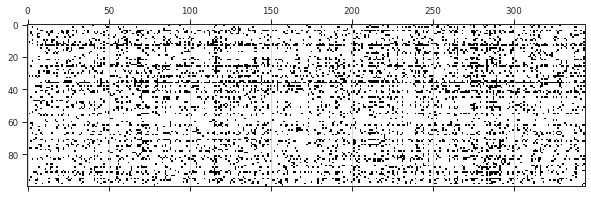

In [62]:
tdm_detailed_gcc_matrix = tdm_detailed_gcc_data.loc[tdm_detailed_gcc_data.status_prediction=='False Negative'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(tdm_detailed_gcc_matrix)

In [63]:
m = tdm_detailed_gcc_matrix.to_numpy()
sparsity_gcc_fn = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity_gcc_fn

0.8411918604651163

# Eclipse

### True Positives
-------------------

#### Word Cloud

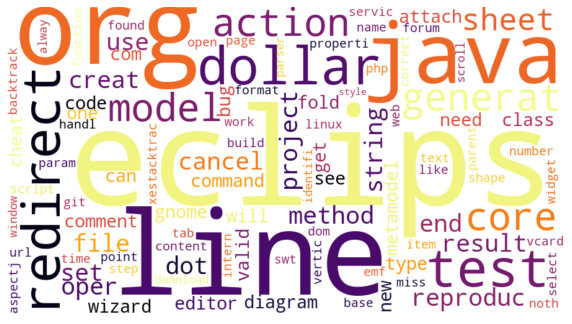

In [64]:
plot_word_cloud(word_frequency_eclipse_data, 'True Positive', 'rq5-eclipse-tp-word_cloud')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


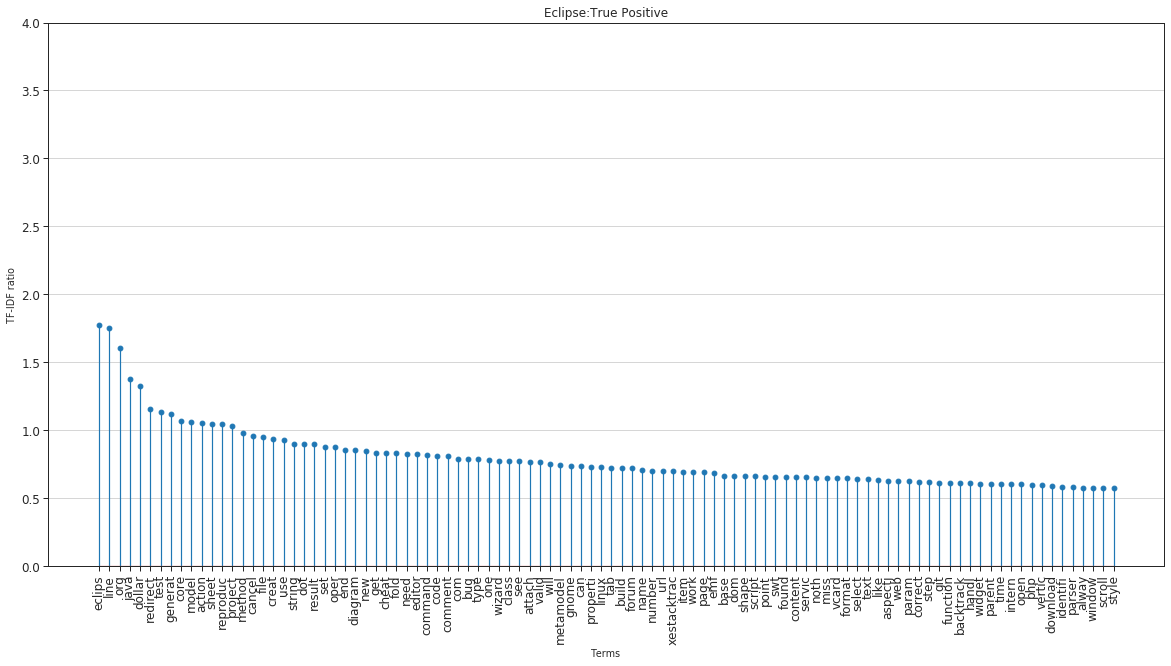

In [65]:
plot_freqs(word_frequency_eclipse_data, (0, 4), 'Eclipse', 'True Positive', 'rq5-eclipse-tp-word_freqs')

In [66]:
word_frequency_eclipse_data.loc[word_frequency_eclipse_data.status_prediction=='True Positive']

,word,freq,status_prediction,project
0,eclips,1.771678,True Positive,eclipse
1,line,1.749890,True Positive,eclipse
2,org,1.604498,True Positive,eclipse
3,java,1.374004,True Positive,eclipse
4,dollar,1.328214,True Positive,eclipse
...,...,...,...,...
95,parser,0.579425,True Positive,eclipse
96,alway,0.577670,True Positive,eclipse
97,window,0.576275,True Positive,eclipse
98,scroll,0.574954,True Positive,eclipse


#### Histogram

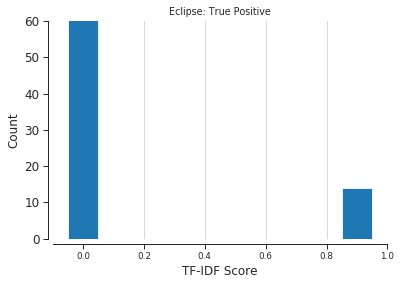

In [67]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status_prediction']=='True Positive']['freq'].astype('int')
         , align='left'
#         , bins=3
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: True Positive")
#plt.xticks([0, 1, 2], fontsize=SMALL_SIZE)
#plt.xlim(0, 2)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-histogram-true-positives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

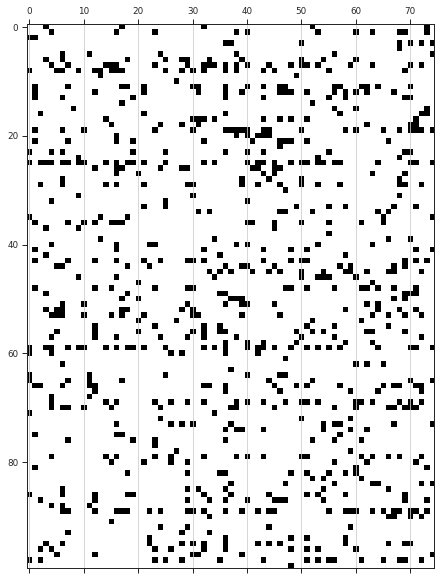

In [68]:
tdm_detailed_eclipse_matrix = tdm_detailed_eclipse_data.loc[tdm_detailed_eclipse_data.status_prediction=='True Positive'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(tdm_detailed_eclipse_matrix)

In [69]:
m = tdm_detailed_eclipse_matrix.to_numpy()
sparsity_eclipse_tp = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity_eclipse_tp

0.8902666666666667

### False Negatives
---

#### Word Cloud

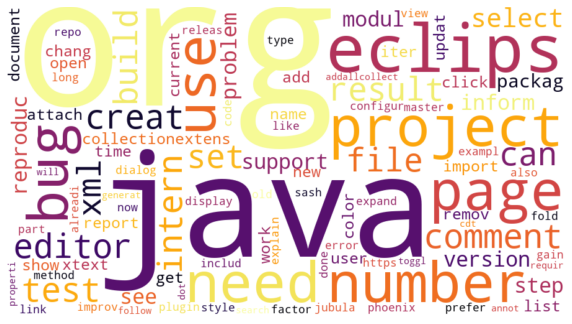

In [70]:
plot_word_cloud(word_frequency_eclipse_data, 'False Negative', 'rq5-eclipse-fn-word_cloud')

/home/luizgomes/apps/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:35: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


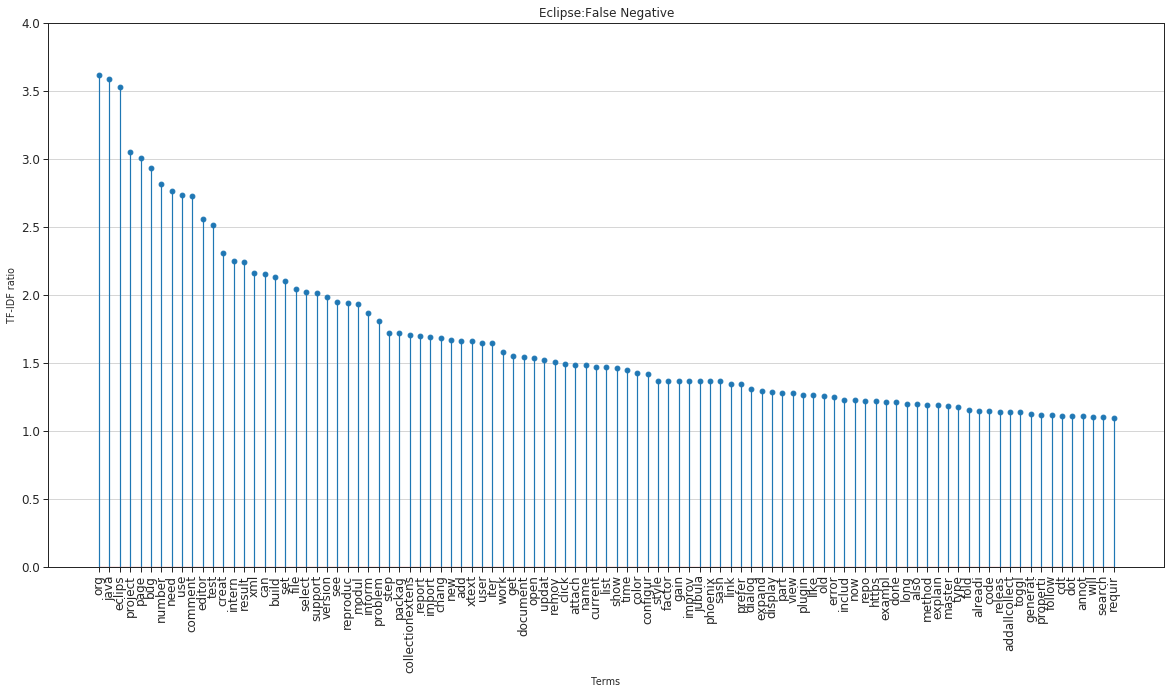

In [71]:
plot_freqs(word_frequency_eclipse_data, (0, 4), 'Eclipse', 'False Negative', 'rq5-eclipse-fn-word_freqs')

#### Histogram

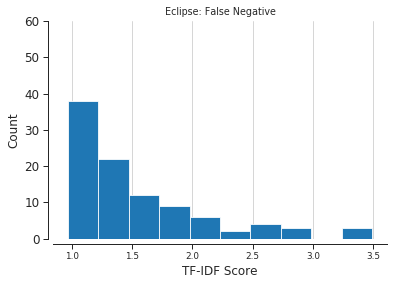

In [72]:
plt.hist(word_frequency_eclipse_data[word_frequency_eclipse_data['status_prediction']=='False Negative']['freq']
         , align='left'
         #, bins=6
         , color='tab:blue')
sns.despine(offset=5)
plt.title("Eclipse: False Negative")
#plt.xticks([0, 2, 6], fontsize=SMALL_SIZE)
#plt.xlim(2, 26)
plt.xlabel('TF-IDF Score', fontsize=SMALL_SIZE)
plt.yticks([0, 10, 20, 30, 40, 50, 60], fontsize=SMALL_SIZE)
plt.ylim(0, 60)
plt.ylabel('Count', fontsize=SMALL_SIZE)
plt.savefig('figures/rq5-eclipse-tf-idf-histogram-false-negatives.pdf', format="pdf", dpi=600, bbox_inches='tight')

#### Sparcity

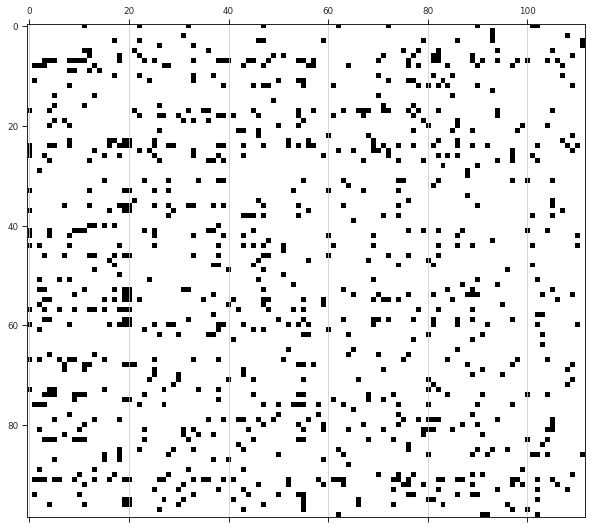

In [73]:
tdm_detailed_eclipse_matrix = tdm_detailed_eclipse_data.loc[tdm_detailed_eclipse_data.status_prediction=='False Negative'].pivot_table(index='Terms', columns='Docs', values='value', fill_value=0.0)
fig, ax = plt.subplots(figsize=(10, 10))
ax.spy(tdm_detailed_eclipse_matrix)

In [74]:
m = tdm_detailed_eclipse_matrix.to_numpy()
sparsity_eclipse_fn = 1.0 - ( count_nonzero(m) / float(m.size) )
sparsity_eclipse_fn

0.9195526695526696

In [75]:
from pandas import DataFrame

metrics = {'dataset': ['Eclipse', 'GCC'],
        'True Positive':  [sparsity_eclipse_tp, sparsity_gcc_tp],
        'False Negative': [sparsity_eclipse_fn, sparsity_gcc_fn]}

df      = DataFrame(metrics)
df.set_index('dataset', inplace=True)


print (df) 

         True Positive  False Negative
dataset                               
Eclipse       0.890267        0.919553
GCC           0.821921        0.841192


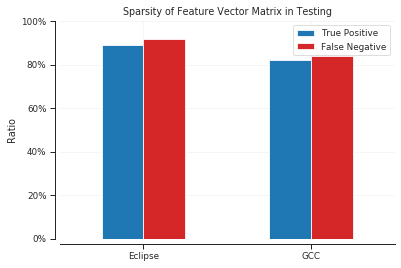

In [76]:
#x=df['% of Long-Lived Bugs']
#y=df['Balanced Accuracy (%)']
import matplotlib.ticker as mtick

ax = df.plot(kind="bar", color=["tab:blue", "tab:red"])
sns.despine(offset=5)

plt.ylim(0, 1)
plt.grid(linestyle='--', linewidth=0.5, alpha=0.5)

plt.title('Sparsity of Feature Vector Matrix in Testing')
plt.xlabel('')
plt.ylabel('Ratio')

ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
plt.savefig('figures/rq5-eclipse-gcc-tp-fn-sparsity.pdf', format="pdf", dpi=600, bbox_inches='tight')